# Transfer Learning CIFAR10

* Train a simple convnet on the CIFAR dataset the first 5 output classes [0..4].
* Freeze convolutional layers and fine-tune dense layers for the last 5 ouput classes [5..9].


###Import necessary libraries for the model

In [0]:
import tensorflow as tf
import numpy as np
import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.metrics import classification_report

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.layers import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


tf.reset_default_graph()
tf.set_random_seed(42)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

### 1. Import CIFAR10 data and create 2 datasets with one dataset having classes from 0 to 4 and other having classes from 5 to 9 

In [0]:
#Get the data from keras dataset...
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [4]:
#Print the count of records in train and test set...
print ("x_train row count: ", len(x_train))
print ("y_train row count: ", len(y_train))
print ("x_test row count: ", len(x_test))
print ("y_test row count: ", len(y_test))

x_train row count:  50000
y_train row count:  50000
x_test row count:  10000
y_test row count:  10000


In [0]:
#As the target dataset has array of array of values, lets convert it to array of values...
y_train = np.array([x[0] for x in y_train])
y_test = np.array([x[0] for x in y_test])

In [0]:
#Split the train data into two with one having classess from 0 to 4 and two having classess from 5 to 9...
x_train0to4 = x_train[y_train<=4]
y_train0to4 = y_train[y_train<=4]
x_train5to9 = x_train[y_train>4]
y_train5to9 = y_train[y_train>4]

In [7]:
#Now get the count of rows in train after split...
print ("x_train0to4 row count: ", len(x_train0to4))
print ("y_train0to4 row count: ", len(y_train0to4))
print ("x_train5to9 row count: ", len(x_train5to9))
print ("y_train5to9 row count: ", len(y_train5to9))

x_train0to4 row count:  25000
y_train0to4 row count:  25000
x_train5to9 row count:  25000
y_train5to9 row count:  25000


In [0]:
#Split the test data into two with one having classess from 0 to 4 and two having classess from 5 to 9...
x_test0to4 = x_test[y_test<=4]
y_test0to4 = y_test[y_test<=4]
x_test5to9 = x_test[y_test>4]
y_test5to9 = y_test[y_test>4]

In [9]:
#Now get the count of rows in test after split...
print ("x_test0to4 row count: ", len(x_test0to4))
print ("y_test0to4 row count: ", len(y_test0to4))
print ("x_test5to9 row count: ", len(x_test5to9))
print ("y_test5to9 row count: ", len(y_test5to9))

x_test0to4 row count:  5000
y_test0to4 row count:  5000
x_test5to9 row count:  5000
y_test5to9 row count:  5000


### 2. Use One-hot encoding to divide y_train and y_test into required no of output classes

In [0]:
#One-hot encoding the train and test datasets...

y_train0to4 = keras.utils.to_categorical(y_train0to4, 5)
y_test0to4 = keras.utils.to_categorical(y_test0to4, 5)

#As the second set have values from 5 to 9... when we do one hot encoding, it will end up with 10 index.
#To avoid it subtract the values by 5, so we have values only from 0 to 4, so while doing one hot encoding the index will be 5.
#Converting the y_train and y_test to have values 0 to 4
#y_train5to9 = y_train5to9 - 5
#y_test5to9 = y_test5to9 - 5 

y_train5to9 = keras.utils.to_categorical(y_train5to9, 10)
y_test5to9 = keras.utils.to_categorical(y_test5to9, 10)

### 3. Build a sequential neural network model which can classify the classes 0 to 4 of CIFAR10 dataset with at least 80% accuracy on test data

#### Preprocessing of Images

In [0]:
#Lets definge a function for Image preprocessing using CV2. 
import cv2

#Clean Data
def CleanData(ImgData):
  Img_clean = []
  for img in ImgData:
    # Convert image to grey scale...
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Resize/Zoom of the image...
    img_grey = cv2.resize(img_grey,None,fx=2, fy=2, interpolation = cv2.INTER_CUBIC)
    
    #blur = cv2.GaussianBlur(img_grey,(5,5),0).astype('uint8')
    #ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    Img_clean.append(img_grey) 
  Img_clean = np.asarray(Img_clean)
  return Img_clean

In [12]:
#After preprocessing lets look at the shape of the images...
print ("x_train0to4 shape: ", x_train0to4.shape)
print ("x_test0to4 shape: ", x_test0to4.shape)
print ("x_train5to9 shape: ", x_train5to9.shape)
print ("x_test5to9 shape: ", x_test5to9.shape)

x_train0to4 shape:  (25000, 32, 32, 3)
x_test0to4 shape:  (5000, 32, 32, 3)
x_train5to9 shape:  (25000, 32, 32, 3)
x_test5to9 shape:  (5000, 32, 32, 3)


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


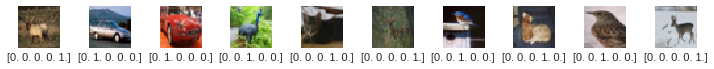

In [13]:
#Visualization of Image before preprocessing...

fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 10))

for i, ax in enumerate(axes.flat, start=0):
    ax.imshow(x_train0to4[i])
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(y_train0to4[i])
    
plt.tight_layout()
plt.show()

In [0]:
#Preprocessing of all images...(train and test sets)
x_train0to4_Cln = CleanData(x_train0to4)
x_test0to4_Cln = CleanData(x_test0to4)
x_train5to9_Cln = CleanData(x_train5to9)
x_test5to9_Cln = CleanData(x_test5to9)

In [15]:
#After preprocessing lets look at the shape of the images...
print ("x_train0to4_Cln shape: ", x_train0to4_Cln.shape)
print ("x_test0to4_Cln shape: ", x_test0to4_Cln.shape)
print ("x_train5to9_Cln shape: ", x_train5to9_Cln.shape)
print ("x_test5to9_Cln shape: ", x_test5to9_Cln.shape)

x_train0to4_Cln shape:  (25000, 64, 64)
x_test0to4_Cln shape:  (5000, 64, 64)
x_train5to9_Cln shape:  (25000, 64, 64)
x_test5to9_Cln shape:  (5000, 64, 64)


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


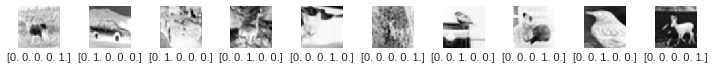

In [16]:
#Visualization of Image after preprocessing...

fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 10))

for i, ax in enumerate(axes.flat, start=0):
    ax.imshow(x_train0to4_Cln[i])
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(y_train0to4[i])
    
plt.tight_layout()
plt.show()

In [0]:
#Reshape the Image...
x_train0to4_Cln = x_train0to4_Cln.reshape(len(x_train0to4_Cln),64,64,1).astype('float32')
x_train5to9_Cln = x_train5to9_Cln.reshape(len(x_train5to9_Cln),64,64,1).astype('float32')
x_test0to4_Cln = x_test0to4_Cln.reshape(len(x_test0to4_Cln),64,64,1).astype('float32')
x_test5to9_Cln = x_test5to9_Cln.reshape(len(x_test5to9_Cln),64,64,1).astype('float32')

#Reduce the range for easy manipulation...
#x_train0to4_Cln = x_train0to4_Cln/255
#x_test0to4_Cln = x_test0to4_Cln/255
#x_train5to9_Cln = x_train5to9_Cln/255
#x_test5to9_Cln = x_test5to9_Cln/255

In [0]:
#### Build the model...

In [18]:
model = Sequential()
model.add(BatchNormalization(input_shape = (64,64,1)))
model.add(Conv2D(filters=32, input_shape = (64,64,1), kernel_size=6, padding='same', kernel_initializer = 'he_normal')) 
model.add(BatchNormalization())
#model.add(LeakyReLU(alpha=0.1))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=5, padding='same', kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
#model.add(LeakyReLU(alpha=0.1))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=4, padding='same', kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
#model.add(LeakyReLU(alpha=0.1))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=3, padding='same', kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
#model.add(LeakyReLU(alpha=0.1))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, padding='same', kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
#model.add(LeakyReLU(alpha=0.1))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Dropout(0.2))

model.add(Flatten()) 

# fully connected layer
model.add(Dense(units=128, kernel_initializer = 'he_normal'))
#model.add(LeakyReLU(alpha=0.1))
model.add(Activation('elu'))
model.add(Dense(units = 64, kernel_initializer = 'he_normal'))
#model.add(LeakyReLU(alpha=0.1))
model.add(Activation('elu'))
model.add(Dropout(0.3))
model.add(Dense(units = 32, kernel_initializer = 'he_normal'))
#model.add(LeakyReLU(alpha=0.1))
model.add(Activation('elu'))
#model.add(Dropout(0.3))
model.add(Dense(units = 5, activation = 'softmax')) 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [19]:
#optimizer = Adam(lr=0.0001)
#opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])
history = model.fit(x_train0to4_Cln, y_train0to4,
                    epochs=20, 
                    validation_data=(x_test0to4_Cln, y_test0to4),
                    verbose = 1,
                    initial_epoch=0,batch_size=100)

Instructions for updating:
Use tf.cast instead.
Train on 25000 samples, validate on 5000 samples
Epoch 1/20
25000/25000 [==============================] - 24s 957us/step - loss: 1.3204 - acc: 0.4656 - val_loss: 0.9894 - val_acc: 0.5892
Epoch 2/20
25000/25000 [==============================] - 22s 866us/step - loss: 0.9954 - acc: 0.6008 - val_loss: 1.0008 - val_acc: 0.6016
Epoch 3/20
25000/25000 [==============================] - 22s 868us/step - loss: 0.8561 - acc: 0.6628 - val_loss: 0.7752 - val_acc: 0.6966
Epoch 4/20
25000/25000 [==============================] - 22s 866us/step - loss: 0.7659 - acc: 0.7031 - val_loss: 0.7110 - val_acc: 0.7262
Epoch 5/20
25000/25000 [==============================] - 22s 865us/step - loss: 0.7011 - acc: 0.7342 - val_loss: 0.6510 - val_acc: 0.7490
Epoch 6/20
25000/25000 [==============================] - 22s 865us/step - loss: 0.6572 - acc: 0.7479 - val_loss: 0.6497 - val_acc: 0.7534
Epoch 7/20
25000/25000 [==============================] - 22s 865us/s

In [0]:
#Get the predictions of the maodel for train and test dataset...
predictions_train = model.predict(x_train0to4_Cln)
predictions_test = model.predict(x_test0to4_Cln)

In [22]:
#Print the train and test accuracy...
print ("Train Accuracy (0-4 classification): ", metrics.accuracy_score(np.argmax(y_train0to4, axis=1), np.argmax(predictions_train, axis=1)))
print ("Test Accuracy (0-4 classification): ", metrics.accuracy_score(np.argmax(y_test0to4, axis=1), np.argmax(predictions_test, axis=1)))

Train Accuracy (0-4 classification):  0.94768
Test Accuracy (0-4 classification):  0.8392


In [23]:
print ("Classification Report for train data (0-4 classification)")
print(classification_report(np.argmax(y_train0to4, axis=1), np.argmax(predictions_train, axis=1)))

Classification Report for train data (0-4 classification)
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      5000
           1       0.99      0.99      0.99      5000
           2       0.90      0.93      0.91      5000
           3       0.96      0.89      0.92      5000
           4       0.94      0.96      0.95      5000

   micro avg       0.95      0.95      0.95     25000
   macro avg       0.95      0.95      0.95     25000
weighted avg       0.95      0.95      0.95     25000



In [24]:
print ("Classification Report for test data (0-4 classification)")
print(classification_report(np.argmax(y_test0to4, axis=1), np.argmax(predictions_test, axis=1)))

Classification Report for test data (0-4 classification)
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      1000
           1       0.96      0.96      0.96      1000
           2       0.75      0.78      0.77      1000
           3       0.83      0.70      0.76      1000
           4       0.81      0.86      0.83      1000

   micro avg       0.84      0.84      0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000



### Observations:
Class 2 and 3 has less f1-score. The model should learn more on this classifications. Data augmentation can be done for these classes and the model can be retrained.

### 4. In the model which was built above (for classification of classes 0-4 in CIFAR10), make only the dense layers to be trainable and conv layers to be non-trainable

In [25]:
#Freezing layers in the model which don't have 'dense' in their name
for layer in model.layers:
  if('dense' not in layer.name): #prefix detection to freeze layers which does not have dense
    #Freezing a layer
    layer.trainable = False

    
#Module to print colourful statements
from termcolor import colored

#Check which layers have been frozen 
for layer in model.layers:
  print (colored(layer.name, 'blue'))
  print (colored(layer.trainable, 'red'))

batch_normalization_1
False
conv2d_1
False
batch_normalization_2
False
activation_1
False
max_pooling2d_1
False
dropout_1
False
conv2d_2
False
batch_normalization_3
False
activation_2
False
max_pooling2d_2
False
dropout_2
False
conv2d_3
False
batch_normalization_4
False
activation_3
False
max_pooling2d_3
False
dropout_3
False
conv2d_4
False
batch_normalization_5
False
activation_4
False
max_pooling2d_4
False
dropout_4
False
conv2d_5
False
batch_normalization_6
False
activation_5
False
max_pooling2d_5
False
dropout_5
False
flatten_1
False
dense_1
True
activation_6
False
dense_2
True
activation_7
False
dropout_6
False
dense_3
True
activation_8
False
dense_4
True


### 5. Utilize the the model trained on CIFAR 10 (classes 0 to 4) to classify the classes 5 to 9 of CIFAR 10  (Use Transfer Learning) <br>
Achieve an accuracy of more than 85% on test data

In [0]:
#Get the output feature shape of pretrained model to pass on to the input of new model.
input_shape = model.output_shape[1]

model5to9 = Sequential()
model5to9.add(model)

#Add some dense layer to the pretrained model...
model5to9.add(Dense(128, activation = 'relu', input_dim=input_shape, kernel_initializer = 'he_normal'))
model5to9.add(Dense(units = 10, activation = 'softmax')) 

In [29]:
model5to9.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])
history = model5to9.fit(x_train5to9_Cln, y_train5to9,
                    epochs=20, 
                    validation_data=(x_test5to9_Cln, y_test5to9),
                    verbose = 1,
                    initial_epoch=0,batch_size=100)

Train on 25000 samples, validate on 5000 samples
Epoch 1/20
25000/25000 [==============================] - 9s 362us/step - loss: 1.1809 - acc: 0.4596 - val_loss: 0.8094 - val_acc: 0.6452
Epoch 2/20
25000/25000 [==============================] - 8s 318us/step - loss: 0.7306 - acc: 0.7108 - val_loss: 0.5146 - val_acc: 0.8308
Epoch 3/20
25000/25000 [==============================] - 8s 330us/step - loss: 0.5546 - acc: 0.8042 - val_loss: 0.4731 - val_acc: 0.8402
Epoch 4/20
25000/25000 [==============================] - 8s 321us/step - loss: 0.5098 - acc: 0.8201 - val_loss: 0.4320 - val_acc: 0.8498
Epoch 5/20
25000/25000 [==============================] - 8s 318us/step - loss: 0.4792 - acc: 0.8288 - val_loss: 0.4132 - val_acc: 0.8540
Epoch 6/20
25000/25000 [==============================] - 8s 318us/step - loss: 0.4678 - acc: 0.8311 - val_loss: 0.4203 - val_acc: 0.8506
Epoch 7/20
25000/25000 [==============================] - 8s 318us/step - loss: 0.4501 - acc: 0.8383 - val_loss: 0.4042 - v

In [0]:
#Get the predictions of the model for train and test dataset...
predictions_train5to9 = model5to9.predict(x_train5to9_Cln)
predictions_test5to9 = model5to9.predict(x_test5to9_Cln)

In [32]:
#Print the train and test accuracy...
print ("Train Accuracy (5-9 classification): ", metrics.accuracy_score(np.argmax(y_train5to9, axis=1), np.argmax(predictions_train5to9, axis=1)))
print ("Test Accuracy (5-9 classification): ", metrics.accuracy_score(np.argmax(y_test5to9, axis=1), np.argmax(predictions_test5to9, axis=1)))

Train Accuracy (5-9 classification):  0.9224
Test Accuracy (5-9 classification):  0.8718


In [35]:
print ("Classification Report for train data (5-9 classification)")
print(classification_report(np.argmax(y_train5to9, axis=1), np.argmax(predictions_train5to9, axis=1)))

Classification Report for train data (5-9 classification)
              precision    recall  f1-score   support

           5       0.92      0.82      0.87      5000
           6       0.93      0.93      0.93      5000
           7       0.85      0.95      0.90      5000
           8       0.95      0.96      0.95      5000
           9       0.97      0.95      0.96      5000

   micro avg       0.92      0.92      0.92     25000
   macro avg       0.92      0.92      0.92     25000
weighted avg       0.92      0.92      0.92     25000



In [34]:
print ("Classification Report for test data (5-9 classification)")
print(classification_report(np.argmax(y_test5to9, axis=1), np.argmax(predictions_test5to9, axis=1)))

Classification Report for test data (5-9 classification)
              precision    recall  f1-score   support

           5       0.86      0.78      0.81      1000
           6       0.90      0.87      0.88      1000
           7       0.79      0.89      0.84      1000
           8       0.90      0.92      0.91      1000
           9       0.92      0.90      0.91      1000

   micro avg       0.87      0.87      0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



### Observations:
Class 5 and 6 has less f1-score. The model should learn more on this classifications. Data augmentation can be done for these classes and the model can be retrained.

# Text classification using TF-IDF

### 6. Load the dataset from sklearn.datasets

In [0]:
from sklearn.datasets import fetch_20newsgroups

In [0]:
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']

### 7. Training data

In [0]:
twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)

### 8. Test data

In [0]:
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

###  a.  You can access the values for the target variable using .target attribute 
###  b. You can access the name of the class in the target variable with .target_names


In [41]:
twenty_train.target

array([1, 1, 3, ..., 2, 2, 2])

In [42]:
twenty_train.target_names

['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']

In [43]:
twenty_train.data[0:5]

['From: sd345@city.ac.uk (Michael Collier)\nSubject: Converting images to HP LaserJet III?\nNntp-Posting-Host: hampton\nOrganization: The City University\nLines: 14\n\nDoes anyone know of a good way (standard PC application/PD utility) to\nconvert tif/img/tga files into LaserJet III format.  We would also like to\ndo the same, converting to HPGL (HP plotter) files.\n\nPlease email any response.\n\nIs this the correct group?\n\nThanks in advance.  Michael.\n-- \nMichael Collier (Programmer)                 The Computer Unit,\nEmail: M.P.Collier@uk.ac.city                The City University,\nTel: 071 477-8000 x3769                      London,\nFax: 071 477-8565                            EC1V 0HB.\n',
 "From: ani@ms.uky.edu (Aniruddha B. Deglurkar)\nSubject: help: Splitting a trimming region along a mesh \nOrganization: University Of Kentucky, Dept. of Math Sciences\nLines: 28\n\n\n\n\tHi,\n\n\tI have a problem, I hope some of the 'gurus' can help me solve.\n\n\tBackground of the probl

### 9.  Now with dependent and independent data available for both train and test datasets, using TfidfVectorizer fit and transform the training data and test data and get the tfidf features for both

In [0]:
vect = TfidfVectorizer()
twenty_train_Vect = vect.fit_transform(twenty_train.data)
twenty_test_Vect = vect.transform(twenty_test.data)

### 10. Use logisticRegression with tfidf features as input and targets as output and train the model and report the train and test accuracy score

In [47]:
from sklearn.linear_model import LogisticRegression

#Fit the train features with LogisticRegression...
logreg = LogisticRegression(C=1e9)
logreg.fit(twenty_train_Vect, twenty_train.target)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [0]:
#Predict the values for train and test...
y_pred_train = logreg.predict(twenty_train_Vect)
y_pred_test = logreg.predict(twenty_test_Vect)

In [49]:
print ("Train Accuracy Score: ", metrics.accuracy_score(twenty_train.target, y_pred_train))
print ("Test Accuracy Score: ", metrics.accuracy_score(twenty_test.target, y_pred_test))

Train Accuracy Score:  1.0
Test Accuracy Score:  0.9260985352862849
